## Adapting The GPT2 for Time Series 

Paper: Autoformer: Decomposition Transformers with
Auto-Correlation for Long-Term Series Forecasting




In [378]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, Subset
from torch.nn import functional as F
from sklearn.model_selection import train_test_split
from typing import Tuple

torch.manual_seed(1)

In [996]:
class TS_Handler:
    
    def __init__(self, df, context_length, n_predict, target_col_idx_list=[-1], test_size=0.2):
        self.context_length = context_length
        self.n_predict = n_predict
        assert self.context_length != 0
        assert self.n_predict != 0
        
        # Load, split without shuffle and make context length exmaples.
        self.ts = torch.tensor(df.values, dtype=torch.float)
        self.ts_len = len(df)
        self.ts_d = df.shape[1]
        self.target_col_idx_list = target_col_idx_list
        
        print(f"{self.ts.shape=}")
        self.train_ts, self.test_ts = train_test_split(self.ts, test_size=0.2, shuffle=False)
        self.X_train, self.y_train = self.make_examples(self.train_ts)
        self.X_test, self.y_test = self.make_examples(self.test_ts)
        
        self.train_dataset = TensorDataset(self.X_train, self.y_train)
        self.test_dataset = TensorDataset(self.X_test, self.y_test)
        print(f"Number of training and testing examples: {len(self.train_dataset)}, {len(self.test_dataset)}")
            
    def pre_process_text(self):
        chars = sorted(list(set(self.raw_text)))
        vocab_size = len(chars)
        stoi = {char: i for i, char in enumerate(chars)}
        itos = {i: char for char, i in stoi.items()}
        return vocab_size, stoi, itos
    
    def make_examples(self, ts, verbose=False):
        n_examples = ts.shape[0] - (self.context_length + self.n_predict)
        X = torch.empty(n_examples, self.context_length, self.ts_d, dtype=torch.float)
        Y = torch.empty(n_examples, self.n_predict, len(self.target_col_idx_list), dtype=torch.float)
        
        # This will have to change for multivariate TS
        for i in range(n_examples):
            X[i] = ts[i:i+self.context_length,:]
            Y[i] = ts[i+self.context_length:i+self.context_length+self.n_predict, self.target_col_idx_list]
            if verbose: print(f"Example {i+1:2d}: {X[i].tolist()} --> {Y[i].item()}")

        return X, Y


# Embedding The Time Series

In [972]:
class TS_Embedding(nn.Module):
    def __init__(self, config , encoder):
        super().__init__()
        self.token_embd = nn.Conv1d(in_channels=config.c_in, out_channels=config.n_embd,
                                   kernel_size=3, padding=1, padding_mode='circular', bias=False)
        
        if encoder:
            self.positional_embd = nn.Embedding(config.context_length, config.n_embd)
        else:
            self.positional_embd = nn.Embedding(config.context_length//2 + config.n_predict, config.n_embd)
            
    
    def forward(self, x):
        n_graphs, n_nodes, c_in = x.size()
        positions = torch.arange(0, n_nodes, dtype=torch.long).unsqueeze(dim=0)
        
        token_embd = self.token_embd(x.transpose(1, 2)).transpose(1, 2)
        positional_embd = self.positional_embd(positions)

        x = token_embd + positional_embd
        return x
        

# Time Series Decomposition

In [824]:

class Moving_Avg(nn.Module):

    def __init__(self, kernel_size, stride):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # Padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x
    
class Series_Decomposition(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.moving_avg = Moving_Avg(kernel_size=config.MA_window, stride=1)

    def forward(self, x):
        trend = self.moving_avg(x)
        residual = x - trend
        return residual, trend
    

# Auto-Correlation Attention 

In [884]:
class Auto_Correlation_Attention(nn.Module):
    
    def __init__(self, config, encoder, cross_attention=False):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.n_head = config.n_head
        self.n_embd = config.n_embd 
        self.projection_factor = 2 if cross_attention else 3
        self.n_nodes = config.context_length if encoder else config.context_length//2 + config.n_predict
        self.top_k_factor = config.top_k_factor
        
        # Layer to generate keys, queries, values (if required) in one pass:
        self.project_components = nn.Linear(config.n_embd, self.projection_factor * config.n_embd)    
        self.output_dropout = nn.Dropout(config.dropout)
    
    def forward(self, x, x_cross=None):

        n_graphs, n_nodes, n_embd = x.size() 
        
        
        # Implement cross attention as well as self attention.
        if x_cross is None:
            queries, keys, values  = self.project_components(x).split(self.n_embd, dim=2)
        else: 
            queries, keys = self.project_components(x_cross).split(self.n_embd, dim=2)
            
            # match up dimensions with some zero padding 
            pad = torch.zeros([n_graphs, n_nodes-queries.shape[1], n_embd], dtype=torch.float)
            queries = torch.concat([queries, pad], dim=1)
            keys = torch.concat([keys, pad], dim=1)
            values = x

            
        queries = queries.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)
        keys = keys.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)
        values = values.view(n_graphs, n_nodes, self.n_head, n_embd // self.n_head)

        # Apply the Wiener–Khinchin theorem to get auto-cov (R) for each embedding dim. 
        queries_fft = torch.fft.rfft(queries.permute(0, 2, 3, 1).contiguous(), dim=-1)
        keys_fft = torch.fft.rfft(keys.permute(0, 2, 3, 1).contiguous(), dim=-1)
        power_spectrum = queries_fft * torch.conj(keys_fft)
        R = torch.fft.irfft(power_spectrum, n=n_nodes, dim=-1)
        
        # Pick the k larest autocorrelations:
        k = int(self.top_k_factor * math.log(n_nodes))
        top_R, lags = torch.topk(R, k=k, dim=-1)
        top_R = torch.softmax(top_R, dim=-1)
        
        # Roll the values, scale them by the auto_covs, add them together.
        # This is'nt nice in terms of kernels, can't use torch.roll as each item in the batch can 
        # be shifted by different amounts so we need to normalise over 
        
        # 1,2,...L for each embedded time series in each head in each batch 
        ordered_idxs = torch.arange(n_nodes).unsqueeze(0).unsqueeze(0).unsqueeze(0)\
            .repeat(n_graphs, self.n_head, n_embd // self.n_head, 1).to(values.device)
        
        # [a,b,c] --> [a,b,c,a,b,c] for each embedding of the value so that we can do a cyclical shift (perumutaion).
        values = values.permute(0, 2, 3, 1).contiguous()
        extended_values = values.repeat(1, 1, 1, 2)
        summed_permuted_values = torch.zeros_like(values).float()

        
        # lags[..., i] -> Gets the ith best lag for each embedding in each head, in each batch.
        # An example for one emedding: say lag = 2
        # init_idxs + lags[..., i].unsqueeze(-1) -> [0,1,2...] -> [2,3,4....]

        for i in range(k):
            permuted_idxs = ordered_idxs + lags[..., i].unsqueeze(-1)
            # Collect the right values across the heads and batch.
            ith_rolled_values = torch.gather(extended_values, dim=-1, index=permuted_idxs)
            # Scale these by the auto-cov and sum up.
            summed_permuted_values = summed_permuted_values + ith_rolled_values * (top_R[..., i].unsqueeze(-1))

        # Concat along across the heads so in.shape = out.shape and dropout
        out = self.output_dropout(summed_permuted_values.permute(0, 3, 1, 2).contiguous().view(n_graphs, n_nodes, n_embd))
     
        return out

In [885]:
class Multi_Layer_Perceptron(nn.Module):

    def __init__(self, config):
        super().__init__()
        # 4X step up as in the paper, and GeLu to stop dead neurons.
        self.fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.nonlin = nn.GELU()

    def forward(self, x):
        x = self.fc(x)
        x = self.nonlin(x)
        x = self.proj(x)
        return x

In [886]:
class Encoder_Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.attn = Auto_Correlation_Attention(config, encoder=True)
        self.sd1 = Series_Decomposition(config)
        self.mlp = Multi_Layer_Perceptron(config)
        self.sd2 = Series_Decomposition(config)
        
    def forward(self, x):
        x = x + self.attn(x)
        # seasonal part goes back in 
        x, _ = self.sd1(x)
        x = x + self.mlp(x)
        residual, trend = self.sd2(x)
        # feed only the seasonal part into the next encoder in the stack. 
        return residual

In [887]:
# x = sd(x) --> decoder
class Decoder_Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.self_attn = Auto_Correlation_Attention(config, encoder=False)
        self.sd1 = Series_Decomposition(config)
        self.cross_attn = Auto_Correlation_Attention(config, encoder=False, cross_attention=True)
        self.sd2 = Series_Decomposition(config)
        self.mlp = Multi_Layer_Perceptron(config)
        # maybe change thse to MLP 
        self.trend_p1 = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.trend_p2 = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.trend_p3 = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.sd3 = Series_Decomposition(config)
        
    def forward(self, res, trend, res_cross):
        res = res + self.self_attn(res)
        res, trend1 = self.sd1(res)
        res = res + self.cross_attn(res, res_cross)
        res, trend2 = self.sd2(res)
        res = res + self.mlp(res)
        residual, trend3 = self.sd3(res)
        
        projected_trend = self.trend_p1(trend1) + self.trend_p2(trend2) + self.trend_p3(trend3)
        trend = trend + projected_trend
        
        return residual, trend

In [1116]:
class TTT(nn.Module):
    
    def __init__(self, config):
        super().__init__()
        assert config.context_length is not None
        self.config = config
        
        self.transformer = nn.ModuleDict(dict(
            sd = Series_Decomposition(config),
            enc_emb = TS_Embedding(config, encoder=True),
            dec_emb = TS_Embedding(config, encoder=False),

            encoder_stack = nn.ModuleList([Encoder_Block(config) for _ in range(config.n_encoders)]),
            decoder_stack = nn.ModuleList([Decoder_Block(config) for _ in range(config.n_decoders)])))
        

        self.decoder_r_proj = nn.Linear(config.n_embd, config.c_in, bias=config.bias)
        self.out_proj = nn.Linear(config.c_in, 1, bias=config.bias)
        # Print the number of parameters
        print("Number of parameters: %d" % (sum(p.nelement() for p in self.parameters()),))
                
    def forward(self, x, targets=None):
        device = x.device
        n_graphs, n_nodes, c_in = x.size()
        assert n_nodes <= self.config.context_length, f"Cannot forward sequence {seq} of length {n_nodes} as it exceeds the maximum context legnth {self.config.context_length}."
        
        # encoder 
        
        x_enc = x[:,n_nodes//2:,:]
        x_en_r, x_en_t = self.transformer.sd(x_enc)
        x_0 = torch.zeros([n_graphs, self.config.n_predict, c_in], device=device)
        x_mean = torch.mean(x_enc, dim=1).unsqueeze(1).repeat(1, self.config.n_predict, 1)
        
        x_0_en = self.transformer.enc_emb(x)
        
        for encoder_block in self.transformer.encoder_stack:
            x_0_en = encoder_block(x_0_en)
        encoder_out = x_0_en
        
        # decoder
        x_de_r = torch.concat((x_en_r, x_0), dim=1)
        x_de_t = torch.concat((x_en_t, x_mean), dim=1)
        
        x_0_de = self.transformer.dec_emb(x_de_r)
                                  
        for decoder_block in self.transformer.decoder_stack:
            x_0_de, x_de_t = decoder_block(x_0_de, x_de_t, encoder_out)
        
        x_de_res_pred = self.decoder_r_proj(x_0_de)
        comb = x_de_res_pred + x_de_t
        
        pred = self.out_proj(comb[:,n_nodes//2:,:])
    
        return pred
        
        

In [984]:
@dataclass
class GPTConfig:
    # Default GPT-2 hyperparameters from the paper
    context_length: int = 96
    c_in: int = 1 # univariate TS
    top_k_factor: int = 1 # Paper: "we set c to the range of 1 to 3."
    MA_window: int = 25 # From paper
    n_encoders: int = 2
    n_decoders: int = 1
    n_predict: int = 96
    n_head: int = 8
    n_embd: int = 512
    dropout: float = 0.1
    bias: bool = False

In [1105]:
class Trainer:
    def __init__(self, text_handler, save_path, config=None, load_path=None):
        self.load_checkpoint(load_path)
        self.text_handler = text_handler
        self.config = config
        self.save_path = save_path
        
    def load_checkpoint(self, path):
        if path is not None:
            # Load the saved model, optimiser state, and losses from checkpoint
            checkpoint = torch.load(path)
            self.config = checkpoint['config']

            self.model = TTT(config)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-1)
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            
            self.train_losses = checkpoint['train_losses']
            self.plot_loss(smoothing_window=1000)
            
        else:
            # Start from scratch
            assert config is not None, "You must provide a configuration for the GPT if training from scratch."
            self.model = TTT(config)
            self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=1e-4, weight_decay=1e-1)
            self.train_losses = []
            
        checkpoint = None # free up memory
    
        
    def train(self, n_epochs, bs, training_data_frac=1):
        self.model.train()
        train_loader = DataLoader(self.text_handler.train_dataset, batch_size=bs, shuffle=True)
        n_batches = int(len(train_loader) * training_data_frac)
        print(f"Training on {n_batches}/{len(train_loader)} batches per epoch.")
        
        for epoch in range(n_epochs):
                for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
                    if batch_idx >= n_batches:
                        break 
                    preds = self.model(X_batch)
                    loss = F.mse_loss(preds.view(-1), y_batch.view(-1))
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    self.optimizer.step()
                    self.train_losses.append(loss.item())
                    print(f"Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.3f}")
        
        self.plot_loss(smoothing_window=10)            
        self.save_checkpoint()
        
    @torch.no_grad()
    def estimate_loss():
        out = {}
        model.eval()
        for split in ['train', 'val']:
            losses = torch.zeros(eval_iters)
            for k in range(eval_iters):
                X, Y = get_batch(split)
                with ctx:
                    logits, loss = model(X, Y)
                losses[k] = loss.item()
            out[split] = losses.mean()
        model.train()
        return out
        
    def train_1_eg(self, n_epochs):
        self.model.train()
        for epoch in range(n_epochs):
            preds = self.model(self.text_handler.X_train[0].unsqueeze(0))
            loss = F.mse_loss(preds.view(-1), self.text_handler.y_train[0].view(-1))
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.train_losses.append(loss.item())
            print(f"Epoch: {epoch}, Loss: {loss.item():.3f}")
        
            
        
    def generate_ts(self, seq, n_steps):
        
        preds = torch.empty((n_steps, seq.shape[-1]))
        seq = seq.unsqueeze(0)        
        
        self.model.eval()
        for i in range(n_steps):
            pred = self.model(seq)
            preds[i] = pred.item()
            seq = torch.concat((seq[:,1:,:], pred.unsqueeze(0)), dim=1)

        return preds

    def save_checkpoint(self):
        self.model.eval()            
        torch.save({'model_state_dict': self.model.state_dict(),
                    'config': self.config,
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_losses': self.train_losses}, self.save_path)
        
    @staticmethod
    def moving_average(data, window_size):
        series = pd.Series(data)
        moving_avg = series.rolling(window=window_size).mean()
        return moving_avg.tolist()
    
    def plot_loss(self, smoothing_window):
        fig, ax = plt.subplots(nrows=1, ncols=1)
        ax.plot(self.moving_average(self.train_losses, smoothing_window))
        ax.set_ylabel("Smoothed Training loss")
     
        

# Training 

In [684]:
url = "https://github.com/zhouhaoyi/ETDataset/raw/main/ETT-small/ETTh1.csv"
# url = "https://raw.githubusercontent.com/AileenNielsen/TimeSeriesAnalysisWithPython/master/data/AirPassengers.csv"

In [690]:
df = pd.read_csv(url, parse_dates=True, index_col=0)

In [1036]:
context_length = 96
n_predict = 96
ts_handler = TS_Handler(df, context_length, n_predict)

self.ts.shape=torch.Size([17420, 7])
Number of training and testing examples: 13744, 3292


In [1107]:
# Train setup
save_path = 'Ts_GPT.pth'
# load_path = 'Ts_GPT.pth'
load_path = None

config = GPTConfig(
    context_length = context_length,
    c_in = ts_handler.ts_d,
    top_k_factor = 1,
    MA_window = 25,
    n_encoders = 2,
    n_decoders = 1,
    n_predict = n_predict,
    n_head = 8,
    n_embd = 512,
    dropout = 0.1,
    bias = False)

model_trainer = Trainer(ts_handler, save_path, config, load_path)


Number of parameters: 9339399


Training on 859/859 batches per epoch.
Epoch: 0, Batch: 0, Loss: 977.147
Epoch: 0, Batch: 1, Loss: 507.163
Epoch: 0, Batch: 2, Loss: 408.408
Epoch: 0, Batch: 3, Loss: 387.500
Epoch: 0, Batch: 4, Loss: 1048.681
Epoch: 0, Batch: 5, Loss: 594.430
Epoch: 0, Batch: 6, Loss: 695.674
Epoch: 0, Batch: 7, Loss: 426.341
Epoch: 0, Batch: 8, Loss: 346.734
Epoch: 0, Batch: 9, Loss: 277.516
Epoch: 0, Batch: 10, Loss: 484.384
Epoch: 0, Batch: 11, Loss: 249.458
Epoch: 0, Batch: 12, Loss: 386.968
Epoch: 0, Batch: 13, Loss: 515.426
Epoch: 0, Batch: 14, Loss: 438.881
Epoch: 0, Batch: 15, Loss: 224.287
Epoch: 0, Batch: 16, Loss: 416.113
Epoch: 0, Batch: 17, Loss: 307.165
Epoch: 0, Batch: 18, Loss: 239.636
Epoch: 0, Batch: 19, Loss: 258.396
Epoch: 0, Batch: 20, Loss: 168.024
Epoch: 0, Batch: 21, Loss: 134.055
Epoch: 0, Batch: 22, Loss: 368.695
Epoch: 0, Batch: 23, Loss: 212.922
Epoch: 0, Batch: 24, Loss: 244.080
Epoch: 0, Batch: 25, Loss: 63.124
Epoch: 0, Batch: 26, Loss: 53.144
Epoch: 0, Batch: 27, Loss: 

Epoch: 0, Batch: 232, Loss: 130.018
Epoch: 0, Batch: 233, Loss: 102.013
Epoch: 0, Batch: 234, Loss: 136.982
Epoch: 0, Batch: 235, Loss: 198.287
Epoch: 0, Batch: 236, Loss: 141.402
Epoch: 0, Batch: 237, Loss: 157.063
Epoch: 0, Batch: 238, Loss: 94.310
Epoch: 0, Batch: 239, Loss: 135.981
Epoch: 0, Batch: 240, Loss: 118.537
Epoch: 0, Batch: 241, Loss: 74.544
Epoch: 0, Batch: 242, Loss: 87.208
Epoch: 0, Batch: 243, Loss: 89.958
Epoch: 0, Batch: 244, Loss: 96.396
Epoch: 0, Batch: 245, Loss: 136.382
Epoch: 0, Batch: 246, Loss: 64.992
Epoch: 0, Batch: 247, Loss: 159.497
Epoch: 0, Batch: 248, Loss: 65.053
Epoch: 0, Batch: 249, Loss: 173.698
Epoch: 0, Batch: 250, Loss: 191.348
Epoch: 0, Batch: 251, Loss: 74.919
Epoch: 0, Batch: 252, Loss: 174.428
Epoch: 0, Batch: 253, Loss: 127.640
Epoch: 0, Batch: 254, Loss: 79.530
Epoch: 0, Batch: 255, Loss: 29.265
Epoch: 0, Batch: 256, Loss: 142.232
Epoch: 0, Batch: 257, Loss: 110.081
Epoch: 0, Batch: 258, Loss: 86.636
Epoch: 0, Batch: 259, Loss: 109.963
Epo

Epoch: 0, Batch: 464, Loss: 64.678
Epoch: 0, Batch: 465, Loss: 50.155
Epoch: 0, Batch: 466, Loss: 64.224
Epoch: 0, Batch: 467, Loss: 66.455
Epoch: 0, Batch: 468, Loss: 30.734
Epoch: 0, Batch: 469, Loss: 61.678
Epoch: 0, Batch: 470, Loss: 54.682
Epoch: 0, Batch: 471, Loss: 50.267
Epoch: 0, Batch: 472, Loss: 55.055
Epoch: 0, Batch: 473, Loss: 77.130
Epoch: 0, Batch: 474, Loss: 40.420
Epoch: 0, Batch: 475, Loss: 64.663
Epoch: 0, Batch: 476, Loss: 41.966
Epoch: 0, Batch: 477, Loss: 29.919
Epoch: 0, Batch: 478, Loss: 71.800
Epoch: 0, Batch: 479, Loss: 91.855
Epoch: 0, Batch: 480, Loss: 50.239
Epoch: 0, Batch: 481, Loss: 59.442
Epoch: 0, Batch: 482, Loss: 55.952
Epoch: 0, Batch: 483, Loss: 58.698
Epoch: 0, Batch: 484, Loss: 48.651
Epoch: 0, Batch: 485, Loss: 60.092
Epoch: 0, Batch: 486, Loss: 75.625
Epoch: 0, Batch: 487, Loss: 83.145
Epoch: 0, Batch: 488, Loss: 51.242
Epoch: 0, Batch: 489, Loss: 55.765
Epoch: 0, Batch: 490, Loss: 54.541
Epoch: 0, Batch: 491, Loss: 54.413
Epoch: 0, Batch: 492

Epoch: 0, Batch: 698, Loss: 59.518
Epoch: 0, Batch: 699, Loss: 34.475
Epoch: 0, Batch: 700, Loss: 39.365
Epoch: 0, Batch: 701, Loss: 39.054
Epoch: 0, Batch: 702, Loss: 38.398
Epoch: 0, Batch: 703, Loss: 36.513
Epoch: 0, Batch: 704, Loss: 29.103
Epoch: 0, Batch: 705, Loss: 26.258
Epoch: 0, Batch: 706, Loss: 47.871
Epoch: 0, Batch: 707, Loss: 26.638
Epoch: 0, Batch: 708, Loss: 34.870
Epoch: 0, Batch: 709, Loss: 30.470
Epoch: 0, Batch: 710, Loss: 40.755
Epoch: 0, Batch: 711, Loss: 34.121
Epoch: 0, Batch: 712, Loss: 43.520
Epoch: 0, Batch: 713, Loss: 50.292
Epoch: 0, Batch: 714, Loss: 50.237
Epoch: 0, Batch: 715, Loss: 38.740
Epoch: 0, Batch: 716, Loss: 46.945
Epoch: 0, Batch: 717, Loss: 32.150
Epoch: 0, Batch: 718, Loss: 87.824
Epoch: 0, Batch: 719, Loss: 29.585
Epoch: 0, Batch: 720, Loss: 40.989
Epoch: 0, Batch: 721, Loss: 48.740
Epoch: 0, Batch: 722, Loss: 33.773
Epoch: 0, Batch: 723, Loss: 30.774
Epoch: 0, Batch: 724, Loss: 79.373
Epoch: 0, Batch: 725, Loss: 40.342
Epoch: 0, Batch: 726

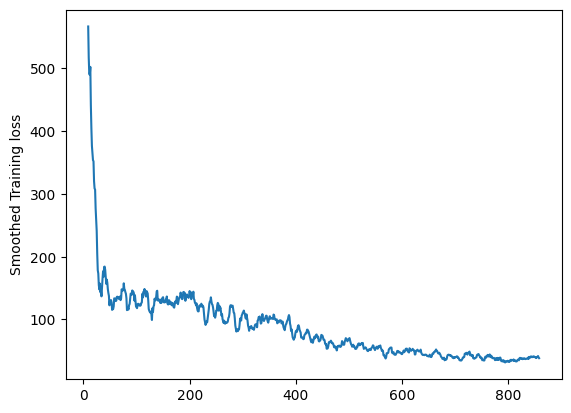

In [1108]:
# Train
bs = 16
n_epochs = 1
training_data_frac = 1
# model_trainer.train_1_eg(n_epochs)
model_trainer.train(n_epochs, bs, training_data_frac)

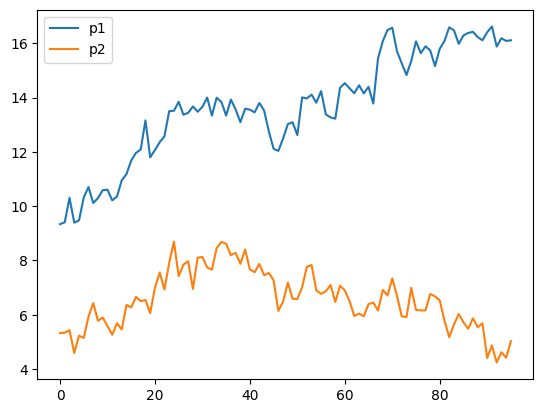

In [1115]:
x1 = ts_handler.X_train[0].unsqueeze(0)
x2 = ts_handler.X_train[97].unsqueeze(0)
pred1 = model_trainer.model(x1).squeeze(0).squeeze(-1).detach().numpy()
pred2 = model_trainer.model(x2).squeeze(0).squeeze(-1).detach().numpy()
fig, ax = plt.subplots()
ax.plot(pred1, label='p1')
ax.plot(pred2, label='p2')
ax.legend()

In [1111]:
x = ts_handler.X_train[20].unsqueeze(0)
y = ts_handler.y_train[20].squeeze(-1)
model_trainer.model.eval()
pred = model_trainer.model(x).squeeze(0).squeeze(-1).detach().numpy()
x.shape, y.shape, pred.shape

(torch.Size([1, 96, 7]), torch.Size([96]), (96,))

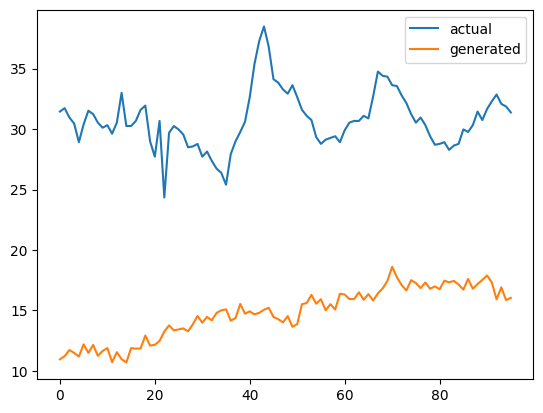

In [1112]:
fig, ax = plt.subplots()
ax.plot(y, label='actual')
ax.plot(pred, label='generated')
ax.legend()

In [564]:
model_trainer.model.eval()
model_trainer.model(ts_handler.X_test[0].unsqueeze(0)), ts_handler.Y_test[0]

(tensor([[381.9994]], grad_fn=<MmBackward0>), tensor([461.]))

In [677]:
starting_ts = ts_handler.X_train[-1]

n_steps = 20
generated_ts = model_trainer.generate_ts(starting_ts, n_steps)
actual = ts_handler.Y_train[:n_steps]

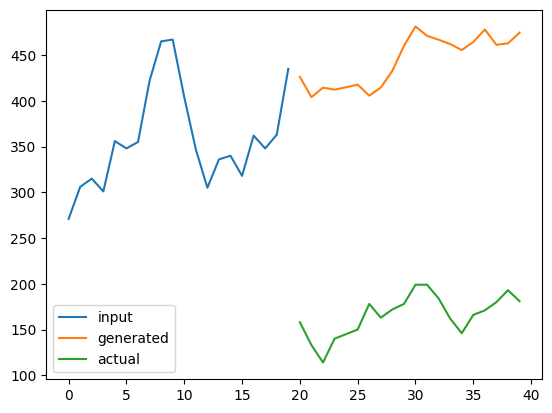

In [678]:
fig, ax = plt.subplots()
t1 = np.arange(config.context_length)
t2 = np.arange(config.context_length, config.context_length+n_steps)
t3 = np.arange(config.context_length, config.context_length+actual.shape[0])

ax.plot(t1, starting_ts, label="input")
ax.plot(t2, generated_ts, label="generated")
ax.plot(t3, actual, label="actual")
ax.legend()